$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\Parents}{\mathrm{Parents}}
\newcommand{\NonDesc}{\mathrm{NonDesc}}
\newcommand{\I}{\mathcal{I}}
\newcommand{\dsep}{\text{d-sep}}
\newcommand{\Cat}{\mathrm{Categorical}}
\newcommand{\Bin}{\mathrm{Binomial}}
$$

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt;
import matplotlib as mpl;
import numpy as np;


## Coin Flipping and EM

Let's work our way through the example presented in lecture. 

### Model and EM theory review

First, let's review the model:

Suppose we have two coins, each with unknown bias $\theta_A$ and $\theta_B$, and collect data in the following way:

1. Repeat for $n=1, \dots, N$:
    1. Choose a random coin $z_n$.
    2. Flip this same coin $M$ times.
    3. Record only the total number $x_n$ of heads.
    

The corresponding probabilistic model is a **mixture of binomials**:
$$
\begin{align}
\theta &= (\theta_A, \theta_B)  &                       
    &&\text{fixed coin biases} \\
Z_n &\sim \mathrm{Uniform}\{A, B \}    & \forall\, n=1,\dots,N
    &&\text{coin indicators} \\
X_n | Z_n, \theta &\sim \Bin[\theta_{Z_n}, M] & \forall\, n=1,\dots,N
    &&\text{head count}
\end{align}
$$

and the corresponding graphical model is:

<img src="coinflip-graphical-model.png">


The **complete data log-likelihood** for a single trial $(x_n,z_n)$ is
$$
\log p(x_n, z_n | \theta) = \log p(z_n) + \log p(x_n | z_n, \theta)
$$
Here, $P(z_n)=\frac{1}{2}$.  The remaining term is
$$
\begin{align} 
\log p(x_n | z_n, \theta)
&= \log \binom{M}{x_n} \theta_{z_n}^{x_n} (1-\theta_{z_n})^{M-x_n} \\
&= \log \binom{M}{x_n} + x_n \log\theta_{z_n} + (M-x_n)\log(1-\theta_{z_n})
\end{align}
$$



### Likelihood Plot

There aren't many latent variables, so we can plot $\log P(\X|\theta_A,\theta_B)$ directly!

In [2]:
def coin_likelihood(roll, bias):
    # P(X | Z, theta)
    numHeads = roll.count("H");
    flips = len(roll);
    return pow(bias, numHeads) * pow(1-bias, flips-numHeads);

def coin_marginal_likelihood(rolls, biasA, biasB):
    # P(X | theta)
    trials = [];
    for roll in rolls:
        h = roll.count("H");
        t = roll.count("T");
        likelihoodA = coin_likelihood(roll, biasA);
        likelihoodB = coin_likelihood(roll, biasB);
        trials.append(np.log(0.5 * (likelihoodA + likelihoodB)));
    return sum(trials);

def plot_coin_likelihood(rolls, thetas=None):
    # grid
    xvals = np.linspace(0.01,0.99,100);
    yvals = np.linspace(0.01,0.99,100);
    X,Y = np.meshgrid(xvals, yvals);
    
    # compute likelihood
    Z = [];
    for i,r in enumerate(X):
        z = []
        for j,c in enumerate(r):
            z.append(coin_marginal_likelihood(rolls,c,Y[i][j]));
        Z.append(z);
    
    # plot
    plt.figure(figsize=(10,8));
    C = plt.contour(X,Y,Z,150);
    cbar = plt.colorbar(C);
    plt.title(r"Likelihood $\log p(\mathcal{X}|\theta_A,\theta_B)$", fontsize=20);
    plt.xlabel(r"$\theta_A$", fontsize=20);
    plt.ylabel(r"$\theta_B$", fontsize=20);
    
    # plot thetas
    if thetas is not None:
        thetas = np.array(thetas);
        plt.plot(thetas[:,0], thetas[:,1], '-k', lw=2.0);
        plt.plot(thetas[:,0], thetas[:,1], 'ok', ms=5.0);

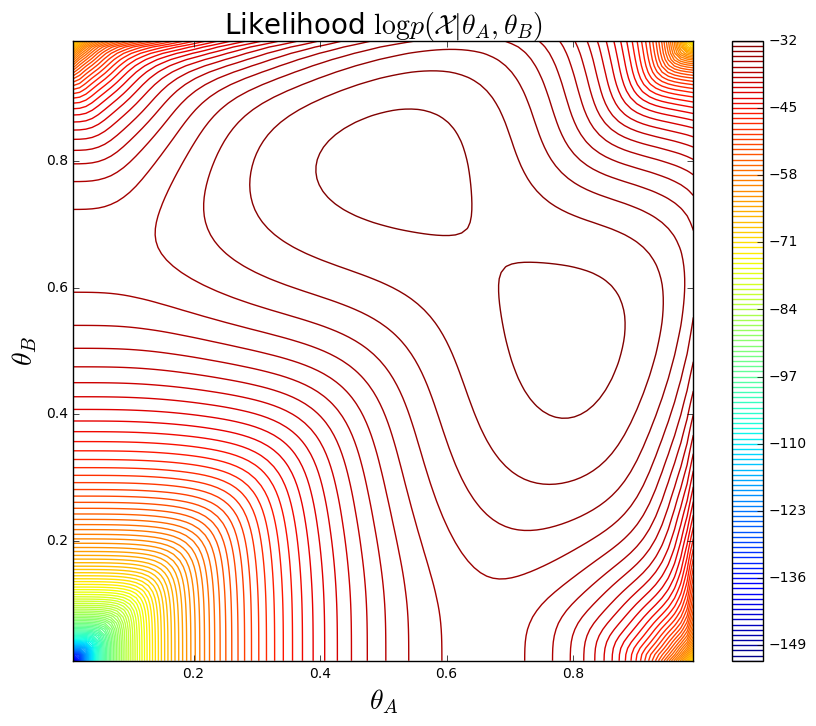

In [3]:
plot_coin_likelihood([ "HTTTHHTHTH", "HHHHTHHHHH", 
         "HTHHHHHTHH", "HTHTTTHHTT", "THHHTHHHTH"]);

For reference (and to make it easier to avoid looking at the solution from lecture :)), here is how to frame EM in terms of the coin flip example:

### E-Step

The **E-Step** involves writing down an expression for
$$
\begin{align}
E_q[\log p(\X, Z | \theta )]                  
&= E_q[\log p(\X | Z, \theta) p(Z)] \\
&= E_q[\log p(\X | Z, \theta)] + \log p(Z) \\
\end{align}
$$

The $\log p(Z)$ term is constant wrt $\theta$, so we ignore it.
> Recall $q \equiv q_{\theta_t} = p(Z | \X,\theta_t)$

\begin{align}
E_q[\log p(\X | Z, \theta)]
&= \sum_{n=1}^N E_q \bigg[
        x_n \log \theta_{z_n} + (M-x_n) \log (1-\theta_{z_n}) 
    \bigg] + \text{const.}
\\
&= \sum_{n=1}^N q_\vartheta(z_n=A)
    \bigg[ x_n \log \theta_A + (M-x_n) {\color{red}{ \log (1-\theta_A)}} \bigg] \\
&+ \sum_{n=1}^N q_\vartheta(z_n=B)
    \bigg[ x_n \log \theta_B + (M-x_n) {\color{red}{\log (1-\theta_B)}} \bigg]
 + \text{const.}
\end{align}


### M-Step

Let $a_n = q(z_n = A)$ and $b_n = q(z_n = B)$.  Taking derivatives with respect to $\theta_A$ and $\theta_B$, we obtain the following update rules:
$$
\theta_A = \frac{\sum_{n=1}^N a_n x_n}{\sum_{n=1}^N a_n M}
\qquad
\theta_B = \frac{\sum_{n=1}^N b_n x_n}{\sum_{n=1}^N b_n M}
$$

> **Interpretation:** For each coin, examples are *weighted* according to the probability that they belong to that coin.  Observing $M$ flips is equivalent to observing $a_n M$ *effective* flips.

## Problem: implement EM for Coin Flips

Using the definitions above and an outline below, fill in the missing pieces.

In [4]:
def e_step(n_flips, theta_A, theta_B):
    """Produce the expected value for heads_A, tails_A, heads_B, tails_B 
    over n_flipsgiven the coin biases"""
    
    # Replace dummy values with your implementation
    heads_A, tails_A, heads_B, tails_B = n_flips, 0, n_flips, 0
    
    return heads_A, tails_A, heads_B, tails_B

def m_step(heads_A, tails_A, heads_B, tails_B):
    """Produce the values for theta that maximize the expected number of heads/tails"""

    # Replace dummy values with your implementation
    theta_A, theta_B = 0.5, 0.5
    
    return theta_A, theta_B

def coin_em(n_flips, theta_A=None, theta_B=None, maxiter=10):
    # Initial Guess
    theta_A = theta_A or random.random();
    theta_B = theta_B or random.random();
    thetas = [(theta_A, theta_B)];
    # Iterate
    for c in range(maxiter):
        print("#%d:\t%0.2f %0.2f" % (c, theta_A, theta_B));
        heads_A, tails_A, heads_B, tails_B = e_step(n_flips, theta_A, theta_B)
        theta_A, theta_B = m_step(heads_A, tails_A, heads_B, tails_B)
        
    thetas.append((theta_A,theta_B));    
    return thetas, (theta_A,theta_B);

In [5]:
rolls = [ "HTTTHHTHTH", "HHHHTHHHHH", "HTHHHHHTHH", 
          "HTHTTTHHTT", "THHHTHHHTH" ];
thetas, _ = coin_em(rolls, 0.1, 0.3, maxiter=6);

#0:	0.10 0.30
#1:	0.50 0.50
#2:	0.50 0.50
#3:	0.50 0.50
#4:	0.50 0.50
#5:	0.50 0.50


### Plotting convergence

Once you have a working implementation, re-run the code below you should be able to produce a convergence plot of the estimated thetas, which should move towards 0.5, 0.8.

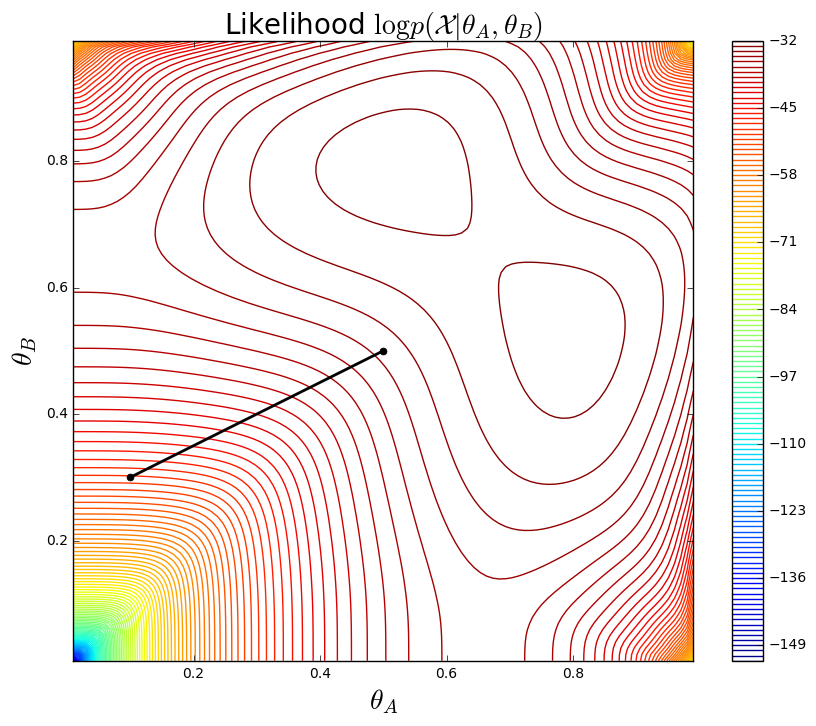

In [6]:
plot_coin_likelihood(rolls, thetas)

## Working with different paramaters

Let's explore some different values for the paramaters of our model.

Here's a method to generate a sample for different values of $Z$ (for the purposes of this example the probability of choosing $A$), $\theta_A$ and $\theta_B$:

In [7]:
import random

def generate_sample(num_flips, prob_choose_a=0.5, a_bias=0.5, b_bias=0.5):
    which_coin = random.random()
    if which_coin < prob_choose_a:
        return "".join(['H' if random.random() < a_bias else 'T' for i in range(num_flips)])
    else:
        return "".join(['H' if random.random() < b_bias else 'T' for i in range(num_flips)])

[generate_sample(10),
 generate_sample(10, prob_choose_a=0.2, a_bias=0.9),
 generate_sample(10, prob_choose_a=0.9, a_bias=0.2, b_bias=0.9)]

['HHHHHTHHHT', 'TTTHHHTHTH', 'HTHHTTTTTT']

## Unequal chance of selecting a coin

Use `generate_sample` to produce a new dataset where:

- coin A is 90% biased towards heads
- coin B is 30% biased towards heads
- the probability of chooising B is 70%

In [8]:
flips = [] # your code goes here

Use your EM implementation and plot its progress over on the liklihood plot and see how well it estimates the true latent parameters underlying the coin flips.

In [9]:
# your code goes here